True
/data/jperez/datasets/HKH_raw/Landsat7_2005/image53.tif {'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1598, 'height': 1901, 'count': 8, 'crs': CRS.from_epsg(32643), 'transform': Affine(30.0, 0.0, 786960.0,
       0.0, -30.0, 3823350.0)} BoundingBox(left=786960.0, bottom=3766320.0, right=834900.0, top=3823350.0)
([78.1067451896069, 78.64701607773699], [33.99829712897009, 34.497395521200794]) 78.1067451896069 78.64701607773699 33.99829712897009 34.497395521200794
Granules found: 1877
 Getting 1877 granules, approx download size: 1.09 GB


QUEUEING TASKS | : 100%|██████████| 1877/1877 [00:00<00:00, 10399.89it/s]


File LE07L1TP1470362005013001T1_LE07L1TP1470362003092201T1_32644_G0240V01_P026.nc already downloaded
File LE07L1TP1470362005013001T1_LE07L1TP1470362003092201T1_32643_G0240V01_P022.nc already downloaded
File LE07L1TP1460372005032801T1_LE07L1TP1460372003100101T1_32644_G0240V01_P051.nc already downloaded
File LE07L1TP1460372005010701T1_LE07L1TP1460372003100101T1_32644_G0240V01_P076.nc already downloaded
File LE07L1TP1460372005031201T1_LE07L1TP1460372003100101T1_32644_G0240V01_P057.nc already downloaded


PROCESSING TASKS | : 100%|██████████| 1877/1877 [05:33<00:00,  5.62it/s]


Error while downloading the file LE07L1TP1470362006101601T1_LE07L1TP1470362005111401T1_32644_G0240V01_P055.nc
Traceback (most recent call last):
  File "/data/jperez/programming/glacier_mapping/.venv/lib/python3.10/site-packages/earthaccess/store.py", line 607, in _download_file
    r.raise_for_status()
  File "/data/jperez/programming/glacier_mapping/.venv/lib/python3.10/site-packages/requests/models.py", line 1021, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 401 Client Error: Unauthorized for url: https://n5eil01u.ecs.nsidc.org/DP4/MEASURES/NSIDC-0775.001/2005.11.14/LE07L1TP1470362006101601T1_LE07L1TP1470362005111401T1_32644_G0240V01_P055.nc



COLLECTING RESULTS | : 100%|██████████| 1877/1877 [00:00<00:00, 447084.37it/s]


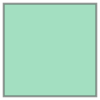

In [25]:
from pathlib import Path

import numpy as np
from pyproj import Transformer
import geopandas as gpd
import earthaccess

from glacier_mapping.data.slice import read_tiff

auth = earthaccess.login()

# for i in range(100):
i = 53
fpath = Path(f"/data/jperez/datasets/HKH_raw/Landsat7_2005/image{i}.tif")
print(fpath.exists())

df = gpd.read_file("./fishnet.geojson")
# print(df.iloc[i].geometry)
# print(type(df.iloc[i].geometry))
# print(df.iloc[i].geometry.bounds)
polygon = list(df.iloc[i].geometry.exterior.coords)

data = read_tiff(fpath)
print(data.name, data.meta, data.bounds)
arr = np.transpose(data.read(), (1, 2, 0)).astype(np.float32)
arr = np.nan_to_num(arr)

xmin, ymin, xmax, ymax = data.bounds
transformer = Transformer.from_crs(data.meta["crs"], 4326, always_xy=True)
bbox = transformer.transform([xmin, xmax], [ymin, ymax])
min_lon, max_lon = bbox[0]
min_lat, max_lat = bbox[1]
print(bbox, min_lon, max_lon, min_lat, max_lat)

assert -180 <= min_lon <= 180
assert -180 <= max_lon <= 180
assert -90 <= min_lat <= 90
assert -90 <= max_lat <= 90
# west -180 to 180
# north -90 to 90
# east -180 to 180
# south -90 to 90
# [west, east, south, north]

# -90 to 90
results = earthaccess.search_data(
    short_name="NSIDC-0775",
    temporal=("2005-01-01", "2005-12-31"),
    # bounding_box=(min_lon, min_lat, max_lon, max_lat),
    # bounding_box=bb2,
    polygon=polygon,
    # count=5,
)

output_dir = Path("./earthaccess") / f"im{i}"
output_dir.mkdir(parents=True, exist_ok=True)
files = earthaccess.download(results, output_dir)
# print(results)
df.iloc[i].geometry

In [40]:
for idx, temp_fpath in enumerate(output_dir.glob("*.nc")):
    xds = rioxarray.open_rasterio(temp_fpath).rio.reproject(data.meta["crs"])
    xds = xds.drop_vars(
        ["mapping", "chip_size_height", "chip_size_width", "v", "interp_mask"]
    )
    xds["vx"].rio.to_raster(output_dir / f"{idx}_vx.tif")
    xds["vy"].rio.to_raster(output_dir / f"{idx}_vy.tif")
    if idx > 0:
        break

: 

In [3]:
# from netCDF4 import Dataset
# import xarray as xr
import rioxarray

import glacier_mapping.data.slice as fn_slice

# geodf = gpd.read_file("./fishnet.geojson")

shp = gpd.read_file("/data/jperez/datasets/HKH_raw/labels/HKH_CIDC_5basins_all.shp")
shp = shp.to_crs(data.meta["crs"].data)
shapefile = fn_slice.clip_shapefile(data.bounds, data.meta, shp)
mask = np.zeros((data.height, data.width, 3))

geom = shapefile
poly_shp = []
im_size = (data.meta["height"], data.meta["width"])
for num, row in geom.iterrows():
    if row["geometry"].geom_type == "Polygon":
        poly_shp.append(
            fn_slice.poly_from_coord(row["geometry"], data.meta["transform"])
        )
    else:
        for p in row["geometry"].geoms:
            poly_shp.append(fn_slice.poly_from_coord(p, data.meta["transform"]))


print(row["geometry"])

/data/jperez/programming/glacier_mapping/.venv/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


POLYGON Z ((806079.30978911 3776951.4902061997 0, 806058.6022465175 3776972.197748792 0, 805988.7232542722 3776989.6674968572 0, 805927.5791360554 3776972.1977487914 0, 805848.9652697792 3776919.7885046056 0, 805796.5560255975 3776919.7885046043 0, 805791.2097603664 3776915.205991553 0, 805789.656259286 3776914.720554903 0, 805788.1834570183 3776914.2098624394 0, 805786.7974164691 3776913.6758086933 0, 805785.4981376423 3776913.118393669 0, 805784.2856205329 3776912.537617362 0, 805783.1598651477 3776911.9334798716 0, 805782.120871478 3776911.305981236 0, 805781.1686395314 3776910.6551214615 0, 805780.3031693038 3776909.9809005433 0, 805779.5244607962 3776909.2833184865 0, 805778.8325139384 3776908.5623752545 0, 805778.227328661 3776907.8180708094 0, 805777.7089049614 3776907.05040515 0, 805777.2772428398 3776906.259378283 0, 805776.9323422986 3776905.4449902056 0, 805776.663691926 3776904.611746115 0, 805776.4496119408 3776903.768937995 0, 805776.2894453813 3776902.916847425 0, 805776

/data/jperez/programming/glacier_mapping/glacier_mapping/data/slice.py:101: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  poly = cascaded_union(polygon)


In [4]:
for temp_fpath in output_dir.glob("*.nc"):
    xds = rioxarray.open_rasterio(temp_fpath)
    xds["v"].rio.to_raster("./debug.tif")
    # df = xds.to_dataframe().reset_index()

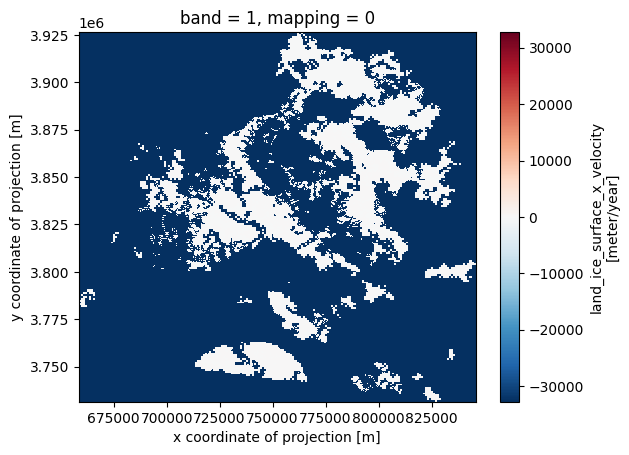

In [7]:
vx = xds["vx"]
vx.plot()

In [23]:
# from shapely.geometry import box
# xds_crs = xds.mapping.geographic_crs_name
# # transformer = Transformer.from_crs(xds_crs, data.meta['crs'], always_xy=True)

# xds_repr = xds.rio.reproject(data.meta['crs'])
# transform_bounds_box = box(*xds.rio.transform_bounds(data.meta['crs']))

# ax = plt.subplot()
# xds_repr['vx'].plot(ax=ax)
# ax.plot(
#     *transform_bounds_box.exterior.xy,
#     color="red",
#     linewidth=3,
# )

# xds.rio.write_crs()
